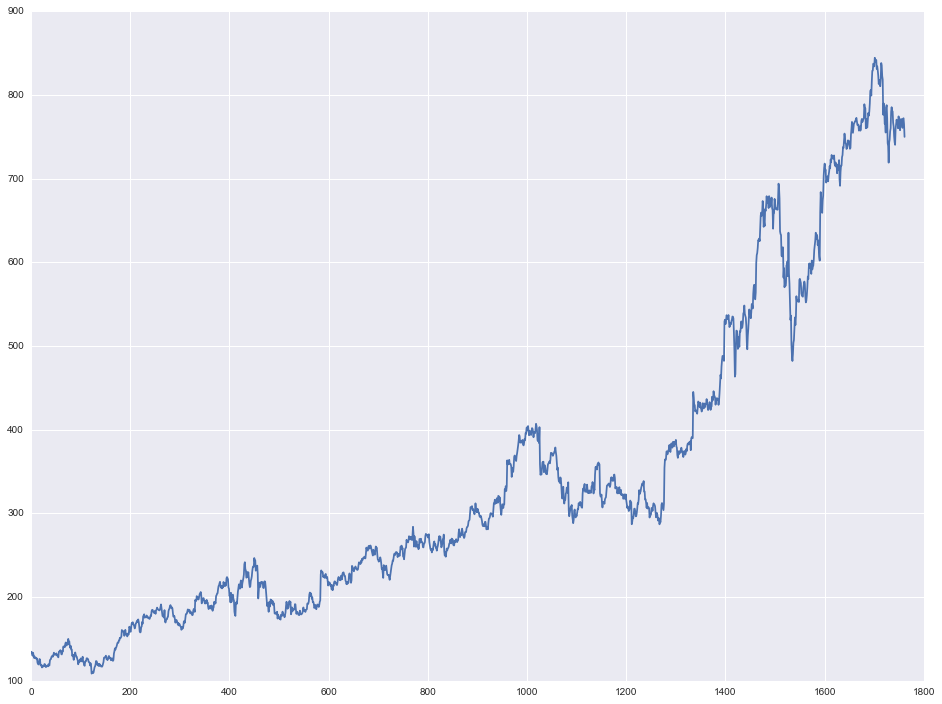

In [4]:
from yahoo_finance import Share
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

stock = "AMZN"

yahoo = Share(stock)
price_history = yahoo.get_historical('2010-01-01', '2017-01-01')

close_price = [ day['Adj_Close'] for day in price_history]
date = [ day['Date'] for day in price_history]

data = pd.DataFrame(dict(price=close_price, date=date))
data['date']  = pd.to_datetime(data.date)


#reverse the order of dataframe
data = data.reindex(index=data.index[::-1])
data.index = range(len(data))

_ = plt.figure(figsize = (16,12))
plt.plot(data['price'])

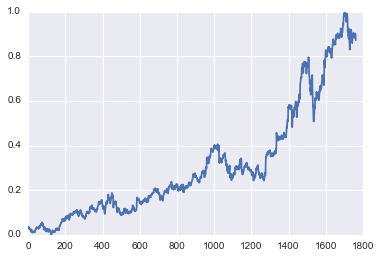

In [10]:
#scale the data to 0-1 for training 
import warnings
from sklearn.preprocessing import MinMaxScaler
warnings.filterwarnings("ignore")

scaler = MinMaxScaler()
data['price'] = scaler.fit_transform(data['price'])
plt.plot(data['price'])

In [182]:
#create lagging for training with time-step
lag = 2

def create_lag(p, lag):
    ret = []
    for i in range(lag + 1):
        ret.append(p.shift(i).values.reshape(-1, 1))
    label = ret.pop(0)
    label = label.astype(np.float32)
    
    ret.reverse()
    data = np.hstack(ret).astype(np.float32)
    #zero padding
    data[np.isnan(data)] = 0
    #reshape for LSTM training
    data = data.reshape(data.shape[0], data.shape[1], 1)
    return data, label

X, Y = create_lag(data.price, lag)

#train - test split
train_x, test_x = X[:1200,:], X[1200:, :]
train_y, test_y = Y[:1200], Y[1200:]

In [183]:
#stateless LSTM 
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import mean_squared_error

filepath = "weights.{epoch:02d}-{mean_squared_error:.2f}.hdf5"
check_point = ModelCheckpoint(filepath, monitor='mean_squared_error', verbose=0, save_best_only=True, save_weights_only=True)
early_stopping = EarlyStopping(patience=2, verbose=0)
call_backs = [early_stopping]

n_sample = X.shape[0]
n_step = X.shape[1]

def build_stateless():
    model = Sequential()
    model.add(LSTM(32, input_shape=(n_step, 1),))
    model.add(Dropout(0.2))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

model = build_stateless()
model.fit(train_x, train_y, nb_epoch=50, verbose=2, batch_size=32, callbacks=call_backs, validation_data=(test_x, test_y))

Train on 1200 samples, validate on 562 samples
Epoch 1/50
0s - loss: 0.0137 - val_loss: 0.0655
Epoch 2/50
0s - loss: 0.0024 - val_loss: 0.0213
Epoch 3/50
0s - loss: 7.4640e-04 - val_loss: 9.5354e-04
Epoch 4/50
0s - loss: 4.4828e-04 - val_loss: 5.9247e-04
Epoch 5/50
0s - loss: 3.7935e-04 - val_loss: 7.8777e-04
Epoch 6/50
0s - loss: 3.3985e-04 - val_loss: 4.8626e-04
Epoch 7/50
0s - loss: 2.8845e-04 - val_loss: 3.1020e-04
Epoch 8/50
0s - loss: 2.4673e-04 - val_loss: 6.2119e-04
Epoch 9/50
0s - loss: 2.6100e-04 - val_loss: 6.4440e-04
Epoch 10/50
0s - loss: 2.5199e-04 - val_loss: 5.8196e-04


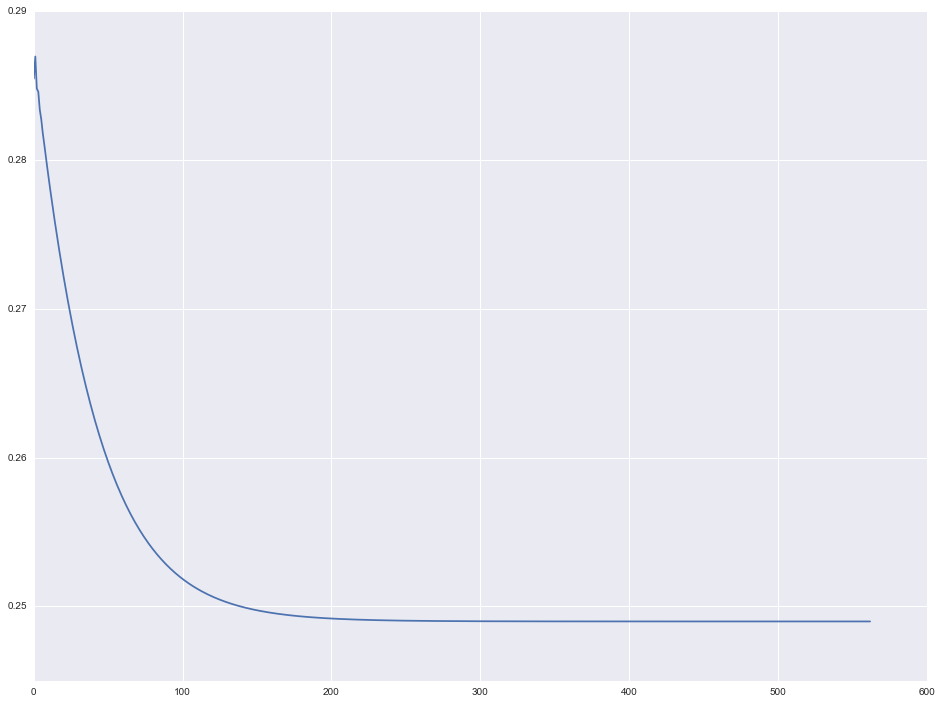

In [184]:
#generating the future stock price series by the model itself
def generate_sequence():
    time_period = len(test_y)

    prediction = []
    #starting with the first lag stock price
    seq_in = test_x[0,:,:].flatten()

    while len(prediction) <= time_period:
        model_input = seq_in[-lag:].reshape((1, lag, 1))
        #predict the price for the next day
        new_price = model.predict(model_input)[0,0]
        prediction.append(new_price)
        seq_in = np.append(seq_in, new_price)
    _ = plt.figure(figsize=(16,12))
    plt.plot(prediction)
    return prediction
prediction = generate_sequence()

In [170]:
#so the naive LSTM is basically trend following?
for i in range(10):
    p =  model.predict(seq_in[i:i+lag].reshape((1,lag,1)))[0,0]
    s = seq_in[i:i+lag]
    print "{} ==> {}".format(s,p)


[ 0.28515121  0.29103634  0.29030243  0.28320763  0.29098201] ==> 0.281065702438
[ 0.29103634  0.29030243  0.28320763  0.29098201  0.2810657 ] ==> 0.279909133911
[ 0.29030243  0.28320763  0.29098201  0.2810657   0.27990913] ==> 0.277730882168
[ 0.28320763  0.29098201  0.2810657   0.27990913  0.27773088] ==> 0.275350511074
[ 0.29098201  0.2810657   0.27990913  0.27773088  0.27535051] ==> 0.273441553116
[ 0.2810657   0.27990913  0.27773088  0.27535051  0.27344155] ==> 0.270440727472
[ 0.27990913  0.27773088  0.27535051  0.27344155  0.27044073] ==> 0.268341362476
[ 0.27773088  0.27535051  0.27344155  0.27044073  0.26834136] ==> 0.266106128693
[ 0.27535051  0.27344155  0.27044073  0.26834136  0.26610613] ==> 0.263868659735
[ 0.27344155  0.27044073  0.26834136  0.26610613  0.26386866] ==> 0.261658847332


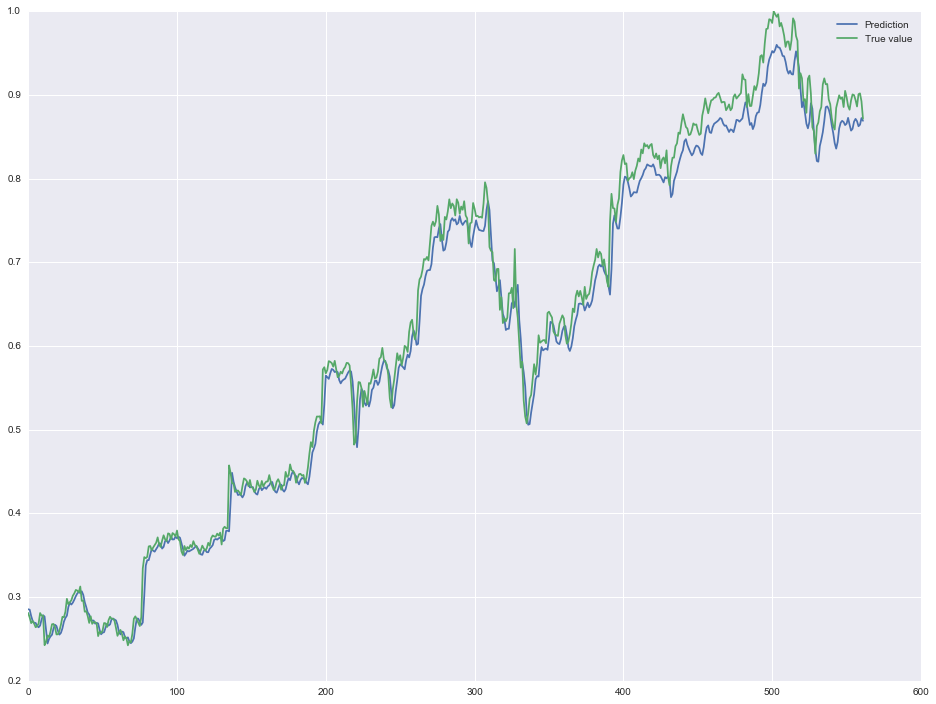

In [185]:
#generating stock price based on previous real prices
prediction = model.predict(test_x)
_ = plt.figure(figsize=(16, 12))
plt.plot(prediction, label='Prediction')
plt.plot(test_y, label="True value")
plt.legend()

MSE at lag 0 is 0.00058195652673
MSE at lag 1 is 0.000361045909813
MSE at lag 2 is 0.000318824604619
MSE at lag 3 is 0.000493773492053
MSE at lag 4 is 0.000677871634252
MSE at lag 5 is 0.00085800193483
MSE at lag 6 is 0.00101820088457
MSE at lag 7 is 0.00117160228547
MSE at lag 8 is 0.00132501358166
MSE at lag 9 is 0.00147561030462


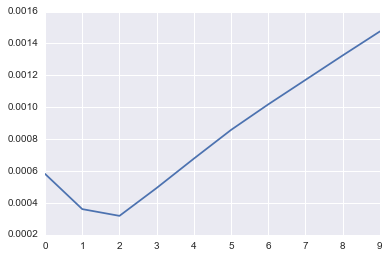

In [186]:
def check_mse():
    #The evaluation of model
    true_value = pd.Series(test_y.flatten())
    #check the MSE of lagged true values
    MSE, lagging = [], []
    for i in range(10):
        lagged_true_value = true_value.shift(i).dropna()
        time_span = len(lagged_true_value)
        mse = mean_squared_error(lagged_true_value, prediction[-time_span:])
        lagging.append(i)
        MSE.append(mse)
        print 'MSE at lag {} is {}'.format(i,mse)
    plt.plot(lagging, MSE)
check_mse()

In [ ]:
#stacked LSTM
